<a href="https://colab.research.google.com/github/nagen01/Colab_Projects/blob/master/bert_fine_tuning_sent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

#Get device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at {}.'.format(device_name))
else:
  raise SystemError("GPU device not found")

Found GPU at /device:GPU:0.


In [0]:
#Verifying GPU with Pytorch:
import torch
if torch.cuda.is_available():
  #Tell pytorch to use GPU
  device = torch.device('cuda')
  print("There are %d GPU(s) available " % torch.cuda.device_count())
  print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
  print("No GPU available, using CPU instead")
  device = torch.device('cpu')


There are 1 GPU(s) available 
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!pip install transformers

     |████████████████████████████████| 481kB 3.2MB/s 
     |████████████████████████████████| 1.0MB 15.7MB/s 
     |████████████████████████████████| 870kB 20.4MB/s 
     |████████████████████████████████| 3.1MB 11.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=f366d58b170fe7c6b604ecffa84058cde577b151c0030861671d4869b7f2bd6d
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
!pip install wget
import os
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=1c92895837b4846d08dde33bdf59970e8dc160c2b64a7e14d755724107552e10
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
print("Downloading the dataset")
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
#if os.path.exists('./cola_public_1.1.zip'):
wget.download(url, './cola_public_1.1.zip')

'./cola_public_1.1.zip'

In [0]:
#Unzip the file
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [0]:
import pandas as pd

df = pd.read_csv('/content/cola_public/raw/in_domain_train.tsv',sep='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print("Number of training samples: {}".format(df.shape[0]))

Number of training samples: 8551


In [0]:
print("Printing top 10 rows:")
print(df.head())
print('\n'*2)
print("Printing random 10 rows:")
print(df.sample(10))

Printing top 10 rows:
  sentence_source  ...                                           sentence
0            gj04  ...  Our friends won't buy this analysis, let alone...
1            gj04  ...  One more pseudo generalization and I'm giving up.
2            gj04  ...   One more pseudo generalization or I'm giving up.
3            gj04  ...     The more we study verbs, the crazier they get.
4            gj04  ...          Day by day the facts are getting murkier.

[5 rows x 4 columns]



Printing random 10 rows:
     sentence_source  ...                                           sentence
2226            l-93  ...                          This knife cut the bread.
7672           sks13  ...                    John believes it to be raining.
1829            r-67  ...  I don't know the boy the flowers who Mary gave...
1680            r-67  ...  It is this hat that it is certain that he was ...
3627            ks08  ...                                 Where did he look?
24              gj04  

In [0]:
#We need to focus on sentence and lable (Sentence is gramatically correct or not)
#Let's find 10 random training samples that are gramatically incorrect
df.loc[df.label == 0].sample(10)[['sentence','label']]

,sentence,label
2957,He turned from a prince.,0
5925,Jennie smiled the sandwich.,0
3218,I gushed the fountain.,0
185,The fatter he goes to a doctor when he gets th...,0
503,John would be hated to win.,0
1567,It never occurred to Harvey because he is inse...,0
1205,Who does Phineas know a girl who is working with?,0
168,"His expectations lower, the higher the stakes.",0
5803,Two or boring books take a very long time to r...,0
3250,Tony bent at the rod.,0


In [0]:
#Let's extract sentences and labels from training data
sentences = df.sentence.values
labels = df.label.values

In [0]:
labels.shape

(8551,)

#Tokenization and formatting
In this section we will tokenize the sentence and format the things in which BERT model can understand the input

#Bert Tokenization
To feed into BERT, sentence must be broken into tokens and tokens must be mapped to their index in the tokenizer vocabulary

Tokenization must be performed by tokenizer (bert-....). Here we will use "bert-base-uncased"

In [0]:
from transformers import BertTokenizer

#Load the tokenizer
print("Loading the bert tokenizer.........")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



Loading the bert tokenizer.........


Let's apply the tokenizer on single sentence

In [0]:
print(f"Original_sentence: {sentences[0]}")
#Tokenize
print(f"Tokenized_words: {tokenizer.tokenize(sentences[0])}")
#Mapping tokens to their respective ids
print(f"Token_ids: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0]))}")

Original_sentence: Our friends won't buy this analysis, let alone the next one we propose.
Tokenized_words: ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token_ids: [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


The above 2 steps can be combined into one as below:
tokenize_encode = tokenize + convert_tokens_to_ids

In [0]:
#print(f"Token_ids in one step by tokenize.encode: {tokenizer.tokenize.encode(sentences[0])}")

##Required formatting
1. Add special tokens at start and end of each sentence
2. Pad/Truncate all sentences to a single constant length
3. Explicitly differienciate real tokens from padding tokens with "Attention_mask"

#Addition of special tokens 
At the starting ([CLS]) and at the end ([SEP]) of each sentence.

[SEP] : Appended at last of each sentence, It try to tell the question asked in 2nd sentence is present in 1st sentence? (Relation).
Still doubt: Why this is used in case of single sentence aswell?

[CLS] : Pretended at the starting of each sequence(not necessarily sentence).

BERT contains 12 transformer layers, each transformer takes a list of token embeddings and produce the same number of embeddings on the output (Feature values changed)

On the output of the final transformer(12th) only first embedding (corrosponding to the [CLS] token) is used by the classifier. "The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks." (from the BERT paper)

ie. BERT is trained to use only this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768 value embeding vector.

#Sentence length and Attention mask
The sentences in our dataset always has varrying lenght, to handle this BERT has 2 constraints:

1. All sentences must be padded or truncated to single fixed lenght.
2. The maximum sentence length is 512 tokens.

Padding is done with special char [PAD], which is at index "0" in BERT vocabulary.

Padding impact both model speed and accuracy....

#Sentence to ids

The tokenizer.encode combines multiple steps
1. Split sentence into tokens
2. Add special [CLS] and [SEP] tokens
3. Map the tokens to their ids

*** This Function can perform truncating but not capable of handling padding

In [0]:
#Tokenize all the sentences and mapping to their tokens:
input_ids = []

for sent in sentences:
  #encode will:
  #1. Tokenize the sentence
  #2. Pretend [CLS]
  #3. Append [SEP]
  #4. Convert tokens to their respective IDs.
  encoded_sent = tokenizer.encode(
      sent,                          #Sentence to encode 
      add_special_tokens=True,       #Add [CLS] and [SEP]
      #This function also support truncation and conversion to pytorch tensors 
      #but we need padding hence can't use these features.
      #max_length = 128,             #Truncate all the sentences
      #return_tensors = 'pt'         #Return pytorch tensors 
      )
  #Add encoded sentence to the list
  input_ids.append(encoded_sent)

#Print sentence[0] for original and IDs
print(f"Original Sentence: {sentences[0]}")
print(f"Token IDs: {input_ids[0]}")

Original Sentence: Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


##Padding and Truncating:

Pad/truncate all the sentence so that all have same length.

In [0]:
#Find the sentence with maximum length:
print(f"Maximum length of the sentence in list: {max([len(sen) for sen in input_ids])}")

Maximum length of the sentence in list: 47


In [0]:
#Here we find maximum length as 47, let's take maximum length as 64 
max_length = 64

from keras.preprocessing.sequence import pad_sequences

print("\n Padding/Truncating all sentences to %d values..." % max_length)
print('\n Padding_token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input values with 0
# 'post' indicate that we want to pad or truncate at the end of the sentence as opposed to the beginning

input_ids = pad_sequences(input_ids, maxlen = max_length, padding = 'post', 
                          truncating = 'post', dtype = 'long', value = 0)

print('\n Done')



 Padding/Truncating all sentences to 64 values...

 Padding_token: "[PAD]", ID: 0

 Done


Using TensorFlow backend.


#Attention mask:
The attention mask make it explicit which token is actual words Vs. which are padding.
The BERT vocabulary dosen't use ID = "0", so if ID is equal to "0" then it's padding otherwise real word.

In [0]:
#Creating attention mask
attention_masks = []

for sent in input_ids:
  #Create attention mask
  #If token id is 0, then it's padding and set the attention mask to 0.
  #If token id is non zero, then it's actual word and set the attention mask to 1.

  attn_mask = [int(token_id > 0) for token_id in sent]

  #For understanding:
  
  #if token_id = 7
  #print(token_id > 0)    will print "True"
  #print(int(token_id > 0))   will print "1"

  #if token_id = 0
  #print(token_id > 0)    will print "False"
  #print(int(token_id > 0))   will print "0"


  #Store the attention mask for this sentence
  attention_masks.append(attn_mask)

#Training and validation:
Divide into training (90%) and test(10%) data

Now we have extracted id's and attentio mask, as per requirement of BERT model


In [0]:
from sklearn.model_selection import train_test_split
#Splitting the token_ids (90:10):
train_input_id, val_input_id, train_labels, val_labels = train_test_split(input_ids, labels,
                                                                            test_size=0.1, random_state=2018 )

#Splitting the attention mask (90:10):
train_mask, validation_mask, _, _  = train_test_split(attention_masks, labels,
                                                      test_size=0.1, random_state=2018 )

In [0]:
print(len(input_ids))
print(len(labels))
print(labels[0])
print(len(train_input_id))
print(train_input_id[0])
print(len(val_input_id))
print(len(train_labels))
print(len(val_labels))
print(len(train_mask))
print(train_mask[0])
print(len(validation_mask))

8551
8551
1
7695
[ 101 2002 2939 1996 3328 1012  102    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
856
7695
856
7695
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
856


#Converting to pytorch data types:
 BERT model expects PyTorch tensors rather than numpy.ndarrays, hence converting all dataset variables into pytorch tensors

In [0]:
train_input_id = torch.tensor(train_input_id)
val_input_id = torch.tensor(val_input_id)

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_mask = torch.tensor(train_mask)
validation_mask = torch.tensor(validation_mask)

In [0]:
print(train_input_id[0])
print(val_input_id[0])
print(train_labels[0])
print(val_labels[0])
print(train_mask[0])
print(validation_mask[0])

tensor([ 101, 2002, 2939, 1996, 3328, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
tensor([  101,  1996, 13176,  3369,  2035,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
tensor(1)
tensor(0)
tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0

We also need to create an iterator for our dataset using the torch DataLoader class which helps save on memory during training because, unlike for a loop, with an iterator the entire dataset dose not need to be loaded into memory.

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [0]:
#Dataloader need to know our batch size for training so we specify it here
#For fine tuning BERT on specific task, authors recommend a batch size of 16 or 32

#Let's take batch size of 32
batch_size = 32

#Create DataLoader for our training set:
train_data = TensorDataset(train_input_id, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

#Create DataLoader for our validation set:
validation_data = TensorDataset(val_input_id, validation_mask, val_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [0]:
print(len(train_data[0]))
print(train_data[0])
print(len(train_data))
print("Since we have taken batch size as 32, 7695/32 ~= 241")
print(f"During training {len(train_dataloader)} samples will be loaded during each batch run")

print(len(validation_data[0]))
print(validation_data[0])
print(len(validation_data))
print("Since we have taken batch size as 32, 856/32 ~= 27")
print(f"During validation {len(validation_dataloader)} samples will be doaded during each batch cycle")

3
(tensor([ 101, 2002, 2939, 1996, 3328, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(1))
7695
Since we have taken batch size as 32, 7695/32 ~= 241
During training 241 samples will be loaded during each batch run
3
(tensor([  101,  1996, 13176,  3369,  2035,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   

##Train our classification Model
Now data is properly formatted and we can proceed for training the model

#BertForSequenceClassification
For this task first we want modify the pretrained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well suited for our task

The Huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of trained BERT model, each has different top layers and output types designed to accomodate their specific NLP tasks.

Current list of classes provided for fine tuning:
BertModel
BertForPreTraining
BertForMaskedLM
BertForNextSentencePrediction
BertForSequenceClassification
BertForTokenClassification
BertForQuestionAnswering

We will be using BertForSequenceClassification, This is normal Bert model with an added single layer on top of classification that we will use as sentence classifier. As we feed training data the entire pre_trained Bert model and the additional untrained classification layer is trained on our specific task.

"bert-base-uncased" : Has only lowercase letters and is smaller version of the two ("base" Vs "large")



In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
#Load the BertForSequentialClassification, the pretrained BERT model with a single linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',       #Uses the 12 layer BERT model with an uncased vocab.
    num_labels = 2,            #The number of outut labels = 2 for binary classification, it can be increased for multi_class task
    output_attentions = False,  #Whether the model returns the attention mask
    output_hidden_states = False # Whether the model return the hidden states
)

#Tell the pytorch model to run on GPU:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

We can browse all the model's parameters by name here

1. The embedding layer
2. The first of the twelve transformers
3. The output layer

In [0]:
#Get all of the model parameters as a list of tuples:
params = list(model.named_parameters())
print("The Bert model has {:}  different named parameters:\n".format(len(params)))

print("\n=====Embedding Layer========\n")
for p in params[0:5]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n===First out of 12 transformers====\n")
for p in params[5:21]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
                                               
print("\n=====Output Layer========\n")
for p in params[-4:]:
  print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))                                     

The Bert model has 201  different named parameters:


=====Embedding Layer========

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

===First out of 12 transformers====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias  

#Optimizer and Learning rate scheduler:
Now model is loaded and we need to get training parameters from within the stored model.

For the purpose of fine_tuning, the authors recommend to choose below values:
1. Batch size: 16 or 32 (we choose 32 when creating dataloader)
2. Learning rate(Adam): 5e-5, 3e-5, 2e-5 (We will use 2e-5)
3. Number of epoch: 2,3 or 4 (We will use 4)

Note: The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"


In [0]:
#Note: AdmW is a class from huggingface library (Oppossed to pytorch)
#W stands for Weight decay fix.

optimizer = AdamW(model.parameters(),
                 lr = 2e-5,     #arg.learning_rate -default is 5e-5, we are using 2e-5
                 eps = 1e-8     #arg.adam_epsilon default is 1e-8
                 )

In [0]:
from transformers import get_linear_schedule_with_warmup

#Number of epoch
epochs = 4

#Total number of training set is number of batches * number of epoch
total_steps = len(train_dataloader)*epochs

#Create learning rate scheduler:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, #Default value in run_glue.py
                                            num_training_steps = total_steps
                                            )


#Training loop:
Lot more is going on, fundamently for each pass in our loop we have a training phase and validation phase and hence at each pass we need to:

Training Loop:


1. Unlock our data inputs and labels.
2. Load data on gpu for accelaration.
3. Clear out gradient calculated at previous pass (In pytorch gradient calculated by default which is useful for things like RRN's unless we explecitely clear them out).
4. Forward pass (Feed input data through the network).
5. Backword pass (Backword propogation).
6. Tell the network to update the parameters with optimizer.step().
7. Track variables for monitoring the progress.

Evaluation Loop:
1. Unpack our data inputs and labels
2. Load data on gpu for accelaration
3. Forward pass(Feed input data through the network)
4. Compute loss on our validation data and track variabls for monitoring purposes




In [0]:
#Creating helper function for calculating the accuracy:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [0]:
#Helper function for formatting elapse time:
import time 
import datetime

def format_time(elapsed):
  #Takes time in seconds and returns in hh:mm:ss format
  #Round to nearest second
  elapsed_rounded = int(round(elapsed))

  #Format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

Ready for kicking off the training

In [0]:
import random

#This training code is based on run_glue.py (Huggingface)

#Set the seed value all over the places to make it reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Store the average loss after each epochs so that we can plot it
loss_values = []

for epoch_i in range(0, epochs):
  #
  #=========Training==========#
  #

  #perform full pass over the training set
  print("")
  print("========= Epoch {:}/{:} =========".format(epoch_i + 1, epochs))
  print("==== Training......")

  #Measure how long the training epoch take time
  t0 = time.time()

  #Reset the total loss for this epoch
  total_loss = 0

  #Put the model into training mode
  model.train()  #Here "train" only change the mode into training and it dosen't perform training
  
  #Note: dropout and batchnorm perform differently during training and testing

  #For each batch in your training data:
  for step, batch in enumerate(train_dataloader):
    #progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      #Calculate elapsed time in minutes:
      elapsed = format_time(time.time() - t0)

      #Report progress:
      print('Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
    #Unpack this trainining batch from dataloader
    #As we unpack dataloader, will also copy each tensor to GPU
    #'batch' contains 3 pytorch tensors: [0]: input_ids, [1]: attention_mask, [2]: labels

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    #Always clear any previously calculated gradients before performing a backword pass.
    #Pytorch dosen't do it automatically because accumulating gradient is convenient while
    #working with RNN's.
    model.zero_grad()

    #Perform the forward pass (Evaluate the model on this training batch).
    #This will return the loss (rather than the output) because we have provided the labels
    outputs = model(b_input_ids,
                   token_type_ids = None,
                   attention_mask = b_input_mask,
                   labels = b_labels)
    
    #The call model always returns a tuple, so we need to pull the loss value from tuple
    loss = outputs[0]

    #Accumulate the overall loss over all of the batches so that we can calculate the average
    #loss at the end, "loss" is Tensor containing single value and the ".item()" function just
    #returns the python value from Tensor.
    total_loss += loss.item()

    #Perform a backword pass to calculate the gradient:
    loss.backward()

    #Clip the norm of gradient to 1.0, this is to help prevent "exploding gradient" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #Update the parameters and take a step using the computed gradient.
    #The optimizer discates the "update-rule" --how the parameters are modified 
    #based on their gradients, the learning rate etc.
    optimizer.step()

    #Update the learning rate:
    scheduler.step()

  #Calculate the average loss over the training data:
  avg_train_loss = total_loss / len(train_dataloader)

  #Store the loss value for ploting the learning curve:
  loss_values.append(avg_train_loss)

  print("")
  print(" Average Training loss: {0:.2f}".format(avg_train_loss))
  print(" Training epoch took : {:}".format(format_time(time.time() - t0)))

  #
  #================== Validation ========================#
  #

  #After completion of each training epochs, measure our performance on validation set

  print("")
  print("Running validation.......")

  t0 = time.time()

  #Put the model in evaluation mode, during evaluation dropout layers behave differently
  model.eval()

  #Tracking variables:
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #Evaluate data for each epochs:
  for batch in validation_dataloader:
    #Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #unpack tuples from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    #Telling the model not to compute or store gradients, saving memory and speeding the validation
    with torch.no_grad():
      #forward pass calculate logit predictions
      #This will return the logits rather than the loss because we have not provided labels
      #token_type_ids are same as segment_ids which differenciate sentence 1 and 2 in 2-sentence tasks.
      outputs = model(b_input_ids,
                      token_type_ids = None,
                      attention_mask = b_input_mask)


    #Get logits output by the model. "logits" are the output values prior to applying to activation
    #function like the softmax.
    logits = outputs[0]

    #Move logits and labels to CPU:
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #Calculate the accuracy for this batch of test sentences
    temp_eval_accuracy = flat_accuracy(logits, label_ids)

    #Accumulate the totel accuracy
    eval_accuracy += temp_eval_accuracy

    #Track the number of batches:
    nb_eval_steps += 1

  #Report the final accuracy for this validation run:
  print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("Validation took: {:}".format(format_time(time.time() - t0)))

#Print training completed
print("========= Training Completed ================")


========= Epoch 1/4 =========
==== Training......
Batch    40 of   241. Elapsed: 0:00:10.
Batch    80 of   241. Elapsed: 0:00:19.
Batch   120 of   241. Elapsed: 0:00:28.
Batch   160 of   241. Elapsed: 0:00:37.
Batch   200 of   241. Elapsed: 0:00:47.
Batch   240 of   241. Elapsed: 0:00:56.

 Average Training loss: 0.49
 Training epoch took : 0:00:56

Running validation.......
Accuracy: 0.81
Validation took: 0:00:02

========= Epoch 2/4 =========
==== Training......
Batch    40 of   241. Elapsed: 0:00:09.
Batch    80 of   241. Elapsed: 0:00:19.
Batch   120 of   241. Elapsed: 0:00:28.
Batch   160 of   241. Elapsed: 0:00:37.
Batch   200 of   241. Elapsed: 0:00:46.
Batch   240 of   241. Elapsed: 0:00:56.

 Average Training loss: 0.30
 Training epoch took : 0:00:56

Running validation.......
Accuracy: 0.82
Validation took: 0:00:02

========= Epoch 3/4 =========
==== Training......
Batch    40 of   241. Elapsed: 0:00:09.
Batch    80 of   241. Elapsed: 0:00:19.
Batch   120 of   241. Elapsed: 

In [0]:
#for step, batch in enumerate(train_dataloader):
#  print(step,batch)  #In this example 241 steps will contains data as per batch
print(loss.item())
#print(outputs[0])

0.11515522748231888


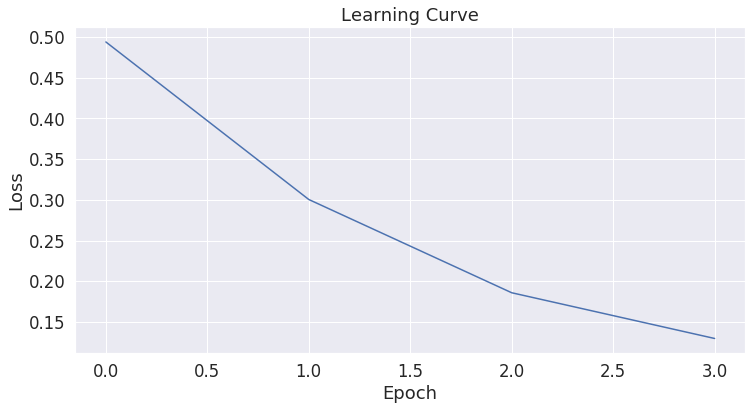

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style = 'darkgrid')

sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12,6)

#Plot the learning curve
plt.plot(loss_values)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

#Performance testing
Now we will load the holdout dataset and prepare input (Preprocess), Then will evaluate using Mathews Correlation Cofficient (This is metric used by wider NLP communities to evaluate performance on Cola. (+1 is best and -1 is worst score))

###Preprocessing

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=max_length, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



###Evaluation on test set

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Accuracy on Cola benchmark is measured  using Matthews Correlation coffecient.

For us classes are imbalance

In [0]:
print("Positive Samples %d of %d (%.2f%%)" %(df.label.sum(), len(df.label), (df.label.sum()/len(df.label)*100)))

Positive Samples 354 of 516 (68.60%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

#Evaluate each test batch using Matthew's correlation coffecient:
print("Calculate Matthew Correlation Coffecient for each batch: ")

for i in range(len(true_labels)):
  #The prediction for this batch are 2 column ndarray, pick the label with highest value that turn
  #this into a list of 0s and 1s.
  pred_lebel_i = np.argmax(predictions[i], axis=1).flatten()

  #Calculate and store the coffecient for this batch:
  matthews = matthews_corrcoef(true_labels[i], pred_lebel_i)
  matthews_set.append(matthews)


Calculate Matthew Correlation Coffecient for each batch: 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Final score will be based on the entire test set but let's see individual score for each batch

All the batches will have 32 sentences in them except the last one which will have (516%32 = 4)

In [0]:
matthews_set

[0.049286405809014416,
 -0.2548235957188128,
 0.4040950971038548,
 0.23372319715296222,
 0.4133804997216296,
 0.7410010097502685,
 0.5269860393922079,
 0.47519096331149147,
 0.8320502943378436,
 0.8805899139163632,
 0.8459051693633014,
 0.647150228929434,
 0.8150678894028793,
 0.7948717948717948,
 0.3268228676411533,
 0.49382916465843113,
 0.0]

In [0]:
#Combine the predictions for each batch into a single list of 0s and 1s
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis = 1).flatten()

#Combine the correct labels for each batch into a single list:
flat_true_labels = [item for sublist in true_labels for item in sublist]

#Calculate the MCC (Matthews Correlation Coffecient):
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print("MCC : %.3f" %mcc)

MCC : 0.540


#Saving and Loading the Fine-Tuned model

Ref: run_glue.py 

In [0]:
import os

output_dir = '.model_save/'

#Create output directory if needed:
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" %output_dir)

#Save the trained model, configuration and tokenizer using "save_pretrained()".
#They can be reloaded using "from_pretrained()".

model_to_save = model.module if hasattr(model, 'module') else model #Take care of distributed parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

#Good prectice is to save training arguments together with trained model
#torch.save(args, os.path.join(output_dir, "training_args.bin"))

Saving model to .model_save/


('.model_save/vocab.txt',
 '.model_save/special_tokens_map.json',
 '.model_save/added_tokens.json')

In [0]:
#Let's check file size:
!ls -l --block-size=k .model_save/

#This shows largest file is model_weights
print("Largest size is in model weights:")
!ls -l --block-size=M .model_save/pytorch_model.bin

total 427960K
-rw-r--r-- 1 root root      2K Feb  5 09:18 config.json
-rw-r--r-- 1 root root 427719K Feb  5 09:18 pytorch_model.bin
-rw-r--r-- 1 root root      1K Feb  5 09:18 special_tokens_map.json
-rw-r--r-- 1 root root      1K Feb  5 09:18 tokenizer_config.json
-rw-r--r-- 1 root root    227K Feb  5 09:18 vocab.txt
Largest size is in model weights:
-rw-r--r-- 1 root root 418M Feb  5 09:18 .model_save/pytorch_model.bin


In [0]:
#Mount google drive to this Notebook Instance
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
#Copy the model file into the directory of google drive:
!cp -r .model_save/ "./drive/My Drive/Colab Notebooks/BERT Fine-Tuning/"

Load the model back from disk

In [0]:
from transformers import AutoModel, AutoTokenizer
#Load a trained model and vocabulary that is fine tuned:
model = AutoModel.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

#Copy the model to GPU:
model.to(device)